# Selection Bias





In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pymc as pm
import arviz as az
import preliz as pz

import xarray as xr
import pytensor.tensor as pt 

from utils import value_counts, decorate

from scipy.special import expit


In [3]:
# Make the figures smaller to save some screen real estate
plt.rcParams["figure.dpi"] = 75
plt.rcParams["figure.figsize"] = [6, 3.5]
plt.rcParams["axes.titlelocation"] = "left"

## SAT Data

Boys who take the SAT get higher math scores than girls, and the difference is consistent.
In data published by the College Board for 2001-2015, the differences were 31, 34, 32, 31, and 31 points.

Reasons for this difference are a topic of debate. They include

* Boys are better at math, on average.

* Boys are better at taking the SAT, so the difference in scores overstates the difference in aptitude.

* Boys who are bad at math are less likely to take the SAT than girls with the same aptitude -- due to this selection bias, the difference in scores overstates the difference in aptitude.

These articles are examples of the debate:

* Mark J. Perry asserts that ["2016 SAT Test Results Confirm Pattern That’s Persisted for 50 Years — High School Boys Are Better at Math Than Girls"](https://www.aei.org/carpe-diem/2016-sat-test-results-confirm-pattern-thats-persisted-for-45-years-high-school-boys-are-better-at-math-than-girls/).

* Wendy Morrison and Grace Finley contend, ["Actually, SAT Results Don’t Confirm Boys Are Better at Math Than Girls"](https://www.aei.org/economics/sat-results-dont-confirm-boys-better-at-math-than-girls/), and they offer alternative explanations for the difference in scores.

* And Perry responds, ["Actually, 50 Years of Test Scores DO Confirm That Boys Outperform Girls on the SAT Math Test"](https://www.aei.org/carpe-diem/actually-50-years-of-test-scores-do-confirm-that-boys-outperform-girls-on-the-sat-math-test/), and explains why he finds the argument for a sampling effect unconvincing.

If it's true that boys with low math aptitude are less likely to take the SAT, we should see evidence of this effect in the distributions of scores, and we may be able to estimate the magnitude of the effect, and what fraction of the difference in scores we observe. 

As data, we'll use distributions of scores reported here:

2011 math: https://secure-media.collegeboard.org/digitalServices/pdf/SAT-Mathemathics_Percentile_Ranks_2011.pdf

2012 math: https://secure-media.collegeboard.org/digitalServices/pdf/research/SAT-Mathemathics-Percentile-Ranks-2012.pdf

2013 math: https://secure-media.collegeboard.org/digitalServices/pdf/research/SAT-Mathematics-Percentile-Ranks-2013.pdf

2014 math: https://web.archive.org/web/20160402182221/https://secure-media.collegeboard.org/digitalServices/pdf/sat/sat-percentile-ranks-mathematics-2014.pdf

2015 math: https://web.archive.org/web/20211222094405/https://secure-media.collegeboard.org/digitalServices/pdf/sat/sat-percentile-ranks-mathematics-2015.pdf

Data for the writing section, and composite scores are also available for some years


2011 writing: https://secure-media.collegeboard.org/digitalServices/pdf/SAT-Writing_Percentile_Ranks_2011.pdf

2011 composite: https://secure-media.collegeboard.org/digitalServices/pdf/SAT-Percentile-Ranks-Composite-CR-M-W-2011.pdf

2011 reading+math: https://secure-media.collegeboard.org/digitalServices/pdf/SAT-Percentile-Ranks-Composite-CR-M_2011.pdf

2012 reading: https://secure-media.collegeboard.org/digitalServices/pdf/research/SAT-Critical-Reading-Percentile-Ranks-2012.pdf

2012 composite: https://secure-media.collegeboard.org/digitalServices/pdf/research/SAT-Percentile-Ranks-Composite-CR-M-W-2012.pdf

2012 reading+math: https://secure-media.collegeboard.org/digitalServices/pdf/research/SAT-Percentile-Ranks-Composite-CR-M-2012.pdf

2013 composite: https://secure-media.collegeboard.org/digitalServices/pdf/research/SAT-Percentile-Ranks-Composite-CR-M-W-2013.pdf

2013 reading+math https://secure-media.collegeboard.org/digitalServices/pdf/research/SAT-Percentile-Ranks-Composite-CR-M-2013.pdf

https://secure-media.collegeboard.org/digitalServices/pdf/research/SAT-Percentile-Ranks-Composite-CR-M-W-2013.pdf



We used a PDF parser to extract the data from the PDF files, and the following function to read the resulting CSV files.

In [4]:
def read_sat_math(year):
    df = pd.read_csv(f'sat_math_{year}.csv', index_col=0)
    df.columns = ['Total', 'Male', 'Female']
    return df

The following dictionary maps from each year (2011-2015) to a Pandas `DataFrame`.

In [5]:
df_map = {}
years = range(2011, 2016)
for year in years:
    df_map[year] = read_sat_math(year)

Here are the total number of test takers in each year.

In [6]:
df_map[2011].sum()

Total     1647123
Male       770605
Female     876518
dtype: int64

In [7]:
df_map[2012].sum()

Total     1664479
Male       778142
Female     886337
dtype: int64

In [8]:
df_map[2013].sum()

Total     1660047
Male       776092
Female     883955
dtype: int64

In [9]:
df_map[2014].sum()

Total     1672395
Male       783570
Female     888825
dtype: int64

In [10]:
df_map[2015].sum()

Total     1698521
Male       794802
Female     903719
dtype: int64

In every year, substantially more girls than boys took the SAT, which is evidence that the selection effect is stronger for boys.

TODO: Get data on the number of boys and girls alive at test-taking age and the number who were enrolled in high school.

The following function converts the number of test-takers with each score into a normalized PMF.

In [11]:
from empiricaldist import Pmf

def make_pmf(df, col):
    pmf = Pmf(df[col])
    pmf.normalize()
    return pmf

Comparing the distribution of scores across years, we can see that the location and spread of the distributions appears consistent.

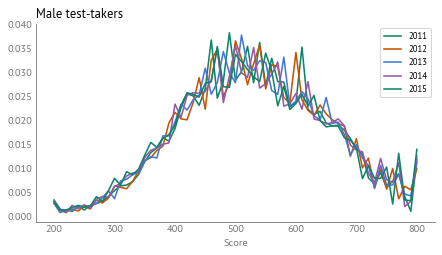

In [12]:
for year, df in df_map.items():
    pmf = make_pmf(df, 'Male')
    pmf.plot(label=year)

decorate(title='Male test-takers')

And likewise for female test takers.

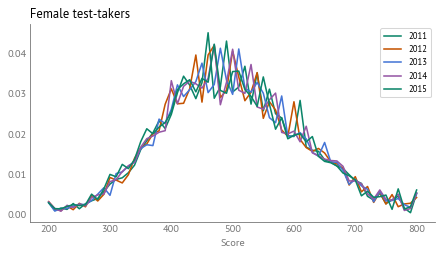

In [13]:
for year, df in df_map.items():
    pmf = make_pmf(df, 'Female')
    pmf.plot(label=year)

decorate(title='Female test-takers')

It is notable that the distributions are spiky.
These perturbations are the result of the way SAT scores are computed.
During 2011-2015 the math section of the SAT typically had 44 multiple choice questions and 10 grid questions.
For the multiple-choice questions, incorrect answers were penalized by 1/4 point.
In each year, some combinations of correct, incorrect, and blank responses were more likely than others.
As a result, the PMF for each year shows a pattern of perturbations that is consistent for male and female test-takers, as shown in the following plots.

In [14]:
def compare_spikes(df_map, year):
    pmf_male = make_pmf(df_map[year], 'Male')
    pmf_male.plot(label='Male')
    
    pmf_female = make_pmf(df_map[year], 'Female')
    pmf_female.plot(label='Female')
    
    mean_male = pmf_male.mean()
    mean_female = pmf_female.mean()
    print(f'Male={mean_male}, Female={mean_female}, Diff={mean_male - mean_female}')
    decorate(title=year)

Male=531.0491886245221, Female=499.6034993006419, Diff=31.44568932388023


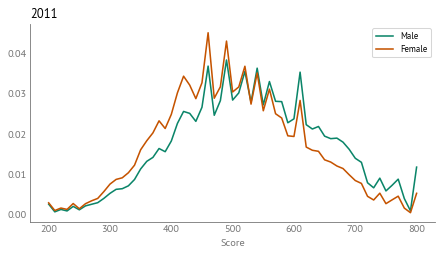

In [15]:
compare_spikes(df_map, 2011)

Male=532.3130225588645, Female=498.5023529425038, Diff=33.81066961636071


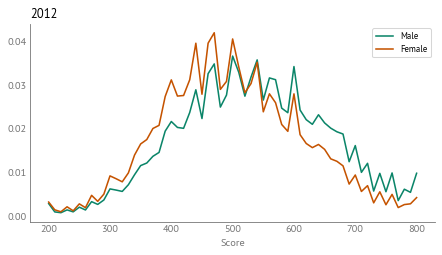

In [16]:
compare_spikes(df_map, 2012)

Male=530.910871391536, Female=499.4024808955207, Diff=31.508390496015352


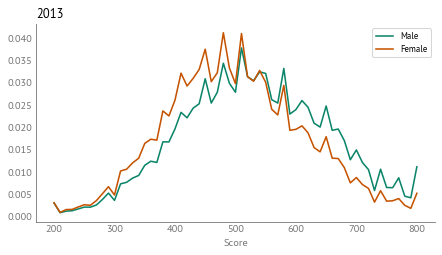

In [17]:
compare_spikes(df_map, 2013)

Male=529.823844710747, Female=498.5317582201221, Diff=31.292086490624968


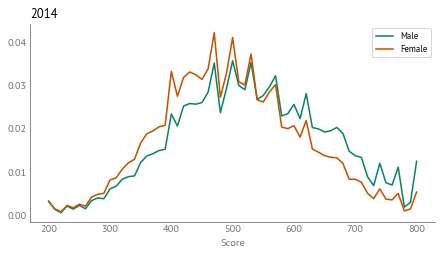

In [18]:
compare_spikes(df_map, 2014)

Male=527.1939174788187, Female=495.92306900706967, Diff=31.27084847174899


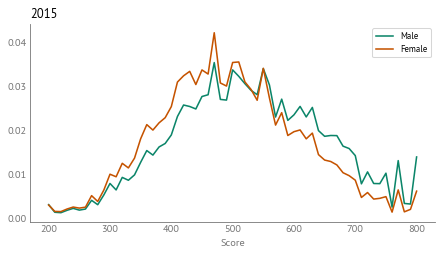

In [19]:
compare_spikes(df_map, 2015)

It is also notable that the extreme scores (200 and 800) are overrepresented, which suggests that test scores don't reflect the full range of aptitude.

We'll use the following function later to plot the relationship between a potential score and the probability of taking the SAT.

In [20]:
def plot_selection_function(idata, col, thetas_centered, **options):
    thetas_xr = xr.DataArray(thetas_centered, dims="theta", coords={"theta": thetas})

    # Extract posterior samples of alpha and beta ---
    posterior = idata.posterior  # shape (chain, draw)

    # Compute logits and apply sigmoid ---
    # logits = posterior["alpha"] + posterior["beta"] * thetas_xr
    logits = posterior["beta"] * thetas_xr
    p = xr.apply_ufunc(expit, logits)

    # Compute median and HDI ---
    median_curve = p.median(dim=["chain", "draw"])
    hdi_bounds = az.hdi(p, hdi_prob=0.94)
    low, high = hdi_bounds['x'].T

    # Plot ---
    plt.plot(thetas, median_curve, **options)
    plt.fill_between(
        thetas,
        low,
        high,
        alpha=0.3,
    )    

## Simple Model

As a first step, we'll build a model that takes data from one year and estimates:

* The mean and standard deviation of the latent distribution of aptitude.

* The parameters of a selection function that relates a potential score to the probability of taking the test.

* The perturbations of the distribution of test scores.

To model the excess of scores at the extremes, we'll assume that the latent distribution of aptitude extends from 100 to 900 -- that is, beyond the range of SAT scores by 100 points at both ends.

In [21]:
full_thetas = np.arange(100, 910, 10)
full_thetas

array([100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220,
       230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350,
       360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480,
       490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610,
       620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740,
       750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870,
       880, 890, 900])

We'll use these masks to select the center part of the distribution, with valid SAT scores, and the tails.

In [22]:
left_mask = full_thetas < 200
right_mask = full_thetas > 800
center_mask = (full_thetas >= 200) & (full_thetas <= 800)

In [23]:
thetas = full_thetas[center_mask]
thetas

array([200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320,
       330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450,
       460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580,
       590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710,
       720, 730, 740, 750, 760, 770, 780, 790, 800])

To fit the model, we'll center and scale the scores to the range from -3 to 3.

In [24]:
thetas_centered = thetas - 500
thetas_centered

array([-300, -290, -280, -270, -260, -250, -240, -230, -220, -210, -200,
       -190, -180, -170, -160, -150, -140, -130, -120, -110, -100,  -90,
        -80,  -70,  -60,  -50,  -40,  -30,  -20,  -10,    0,   10,   20,
         30,   40,   50,   60,   70,   80,   90,  100,  110,  120,  130,
        140,  150,  160,  170,  180,  190,  200,  210,  220,  230,  240,
        250,  260,  270,  280,  290,  300])

In [71]:
scale = 100
thetas_scaled = thetas_centered / scale
np.min(thetas_scaled), np.max(thetas_scaled), 

(np.float64(-3.0), np.float64(3.0))

As an example, we'll run the model for a single year and sex.

In [26]:
year = 2015
sex = 'Male'
counts_obs = df_map[year].loc[thetas, sex]
counts_obs

Score
200     2456
210     1071
220      995
230     1426
240     1779
       ...  
760     2004
770    10434
780     2673
790     2563
800    11098
Name: Male, Length: 61, dtype: int64

In [72]:
N_test_obs = int(counts_obs.sum())
N_test_obs

794802

The parameter `beta` estimates the strength of the selection affect.
As a prior, we'll use a gamma distribution, which is positive valued, reflecting the expectation that if a selection effect exists, people with higher scores are *more* likely to take the test.
The high density interval of the prior is chosen to be weakly informative -- that is, it does not substantially affect the results.

{'alpha': np.float64(4.300178987723759), 'beta': np.float64(83.84212820172407)}

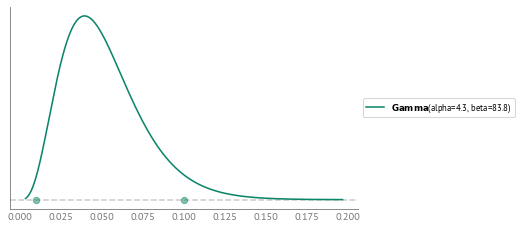

In [28]:
dist, plot = pz.maxent(pz.Gamma(), lower=0.01, upper=0.1, mass=0.95)
beta_params = dist.params_dict
beta_params

For the standard deviation of aptitude, we also use a gamma distribution, with a high density  interval wide enough to cover all likely values.

{'alpha': np.float64(22.785324935720883),
 'beta': np.float64(0.23070884391059038)}

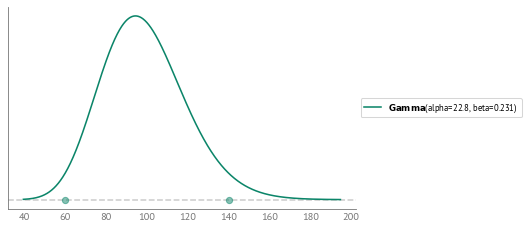

In [29]:
dist, plot = pz.maxent(pz.Gamma(), lower=60, upper=140, mass=0.95)
sigma_params = dist.params_dict
sigma_params

Now here's the model.

In [30]:
def make_model(N_test_obs, counts_obs):
    with pm.Model() as model:
        # Latent population score distribution
        mu = pm.Normal("mu", mu=500, sigma=30)
        sigma = pm.Gamma("sigma", **sigma_params)
        
        # Prior for the parameter of the selection effect
        beta = pm.Gamma("beta", **beta_params)

        # Compute hypothetical distribution of aptitude
        logp_vals = pm.logp(pm.Normal.dist(mu=mu, sigma=sigma), full_thetas)

        # To generate perturbations, generate Gaussian noise and compute diffs
        log_noise_raw = pm.Normal("log_noise_raw", mu=0.0, sigma=0.05, 
                                  shape=(len(full_thetas)+1,))
        log_noise = pm.Deterministic("log_noise", pt.diff(log_noise_raw))

        # Perturb the distribution (subtracting the mean for identifiability)
        perturbed_logp = logp_vals + log_noise - pm.math.mean(log_noise)
        logp_normalizer = pm.math.logsumexp(perturbed_logp)
        pop_pdf = pm.Deterministic("pop_pdf", pm.math.exp(perturbed_logp - logp_normalizer))

        # Roll up the tail probabilities
        left_mass = pop_pdf[left_mask].sum()
        right_mass = pop_pdf[right_mask].sum()
        center_pdf = pop_pdf[center_mask]

        # Add the tail probabilities to the extreme scores
        center_pdf = pt.set_subtensor(center_pdf[0], center_pdf[0] + left_mass)
        center_pdf = pt.set_subtensor(center_pdf[-1], center_pdf[-1] + right_mass)

        # Compute the selection model (linear on a logit scale)
        logits = beta * thetas_scaled
        p_take = pm.Deterministic("p_take", pm.math.sigmoid(logits))

        # Multiply the distribution of scores by the probability of taking the test
        # and normalize the product
        test_unnorm = center_pdf * p_take
        prob_test = pm.math.sum(test_unnorm)
        test_pdf = test_unnorm / pm.math.sum(test_unnorm)

        # Multinomial likelihood for binned scores
        pm.Multinomial("obs_bins", n=N_test_obs, p=test_pdf, observed=counts_obs)
        
    return model

Here's a sample from the prior distributions.

In [31]:
model = make_model(N_test_obs, counts_obs)

with model:
    prior = pm.sample_prior_predictive(1000)

Sampling: [beta, log_noise_raw, mu, obs_bins, sigma]


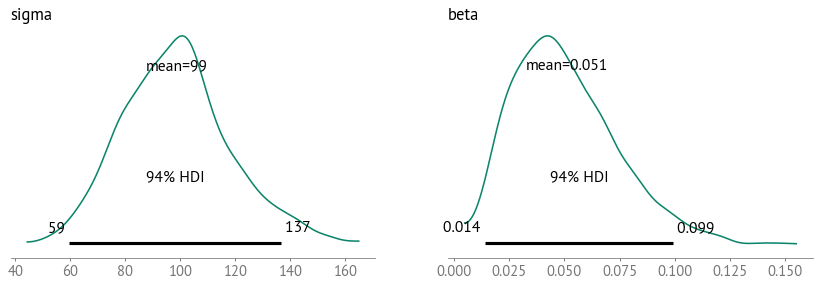

In [32]:
az.plot_posterior(prior, group='prior', var_names=['sigma', 'beta']);

And here's how we fit the model.

In [33]:
with model:
    idata = pm.sample(target_accept=0.95)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, beta, log_noise_raw]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.


The model samples well and passes diagnostics.

In [34]:
pm.summary(idata, var_names=['mu', 'sigma', 'beta'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,526.031,0.664,524.848,527.180,0.010,0.014,4628.0,2726.0,1.0
sigma,124.096,0.118,123.874,124.318,0.002,0.002,3277.0,3146.0,1.0
beta,0.018,0.009,0.003,0.033,0.000,0.000,4886.0,2664.0,1.0


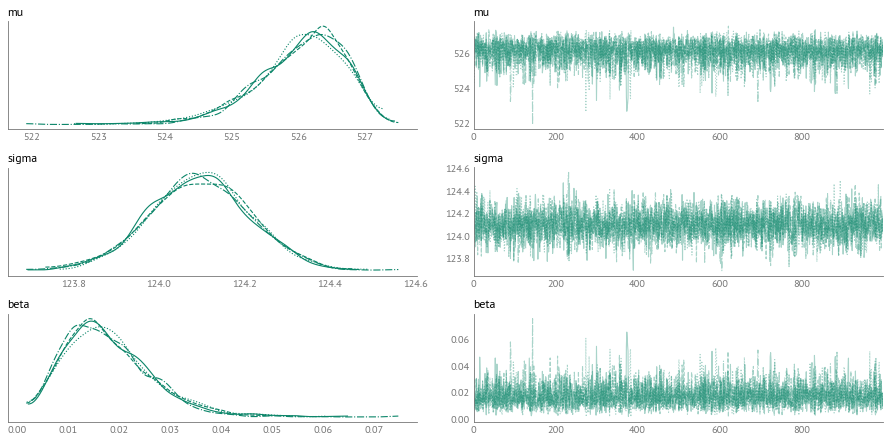

In [35]:
pm.plot_trace(idata, var_names=['mu', 'sigma', 'beta'])
decorate()

Here are the posterior distributions.

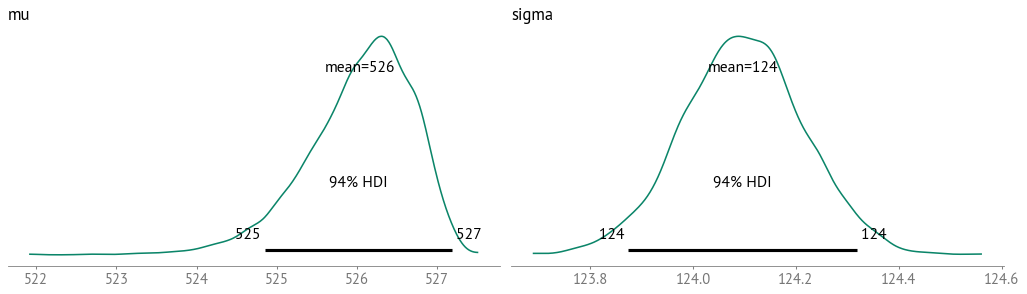

In [36]:
pm.plot_posterior(idata, var_names=['mu', 'sigma'])
decorate()

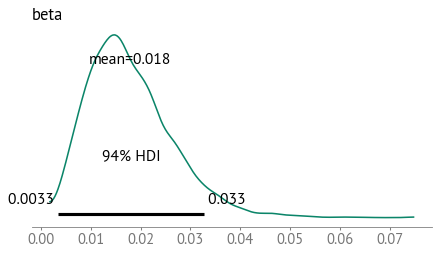

In [37]:
pm.plot_posterior(idata, var_names=['beta'])
decorate()

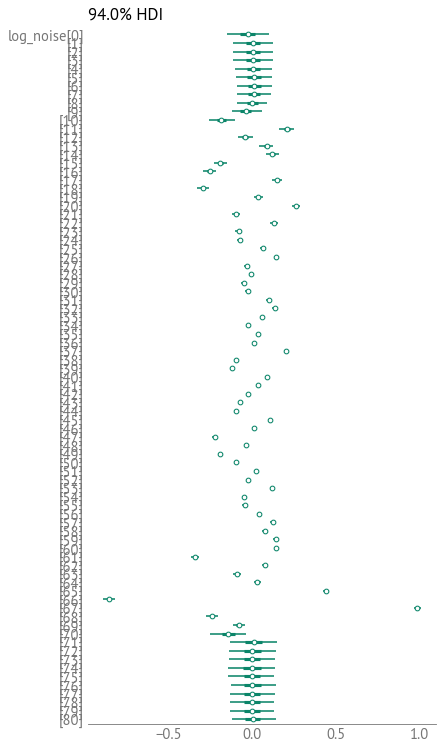

In [38]:
az.plot_forest(idata, var_names='log_noise', combined=True);

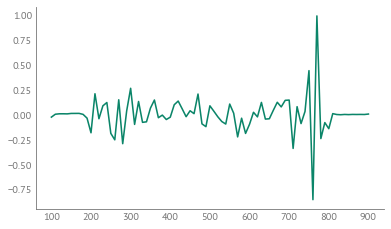

In [39]:
log_noise = np.median(az.extract(idata)['log_noise'], axis=1)
plt.plot(full_thetas, log_noise);

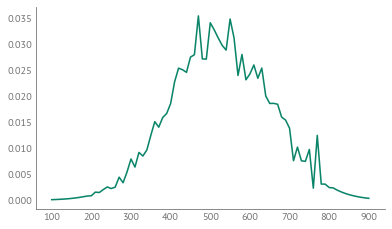

In [40]:
pop_pdf = np.median(az.extract(idata)['pop_pdf'], axis=1)
plt.plot(full_thetas, pop_pdf);

Here's what the selection function looks like, indicating the *relative* probability of taking the test for a range of potential scores.
These probabilities are scaled so the midpoint is 50%.
The left side indicates how much less likely someone is to take the test if their potential score is low.

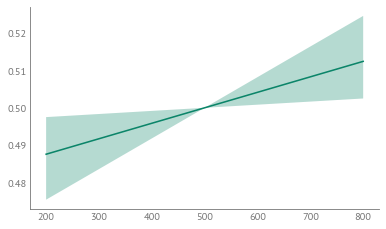

In [41]:
plot_selection_function(idata, 'sat_math', thetas_scaled)

## Parameter recovery

In [42]:
def generate_with_pymc(
    N_test, true_mu, true_sigma, true_beta, true_log_noise_raw, random_seed=123
):
    with pm.Model() as gen:
        # Fixed “true” parameters as constants (no uncertainty)
        mu = pm.Data("mu", true_mu)
        sigma = pm.Data("sigma", true_sigma)
        beta = pm.Data("beta", true_beta)
        log_noise = pm.Data("log_noise", true_log_noise)

        # Compute perturbed log population PDF
        logp_vals = pm.logp(pm.Normal.dist(mu=mu, sigma=sigma), full_thetas)
        perturbed_logp = logp_vals + log_noise - pm.math.mean(log_noise)
        logp_normalizer = pm.math.logsumexp(perturbed_logp)
        pop_pdf = pm.Deterministic("pop_pdf", pm.math.exp(perturbed_logp - logp_normalizer))

        # tails → center
        left_mass  = pop_pdf[left_mask].sum()
        right_mass = pop_pdf[right_mask].sum()
        center_pdf = pop_pdf[center_mask]
        center_pdf = pt.set_subtensor(center_pdf[0],  center_pdf[0]  + left_mass)
        center_pdf = pt.set_subtensor(center_pdf[-1], center_pdf[-1] + right_mass)

        # selection
        logits = beta * thetas_scaled
        p_take = pm.Deterministic("p_take", pm.math.sigmoid(logits))

        # test-taker score distribution
        test_unnorm = center_pdf * p_take
        prob_test = pm.Deterministic("prob_test", test_unnorm.sum())
        test_pdf = pm.Deterministic("test_pdf", test_unnorm / test_unnorm.sum())

        # generate synthetic data
        obs_bins = pm.Multinomial("obs_bins", n=N_test, p=test_pdf)

        prior_pred = pm.sample_prior_predictive(
            draws=1,
            var_names=["obs_bins", "prob_test", "test_pdf", "p_take", "pop_pdf"],
            random_seed=random_seed,
        )
        return prior_pred


In [43]:
N_test=1_500_000
true_mu=526
true_sigma=124
true_beta=0.018
true_log_noise = log_noise

prior_pred = generate_with_pymc(
    N_test, true_mu, true_sigma, true_beta, true_log_noise, random_seed=4
)

Sampling: [obs_bins]


In [44]:
counts_draw = np.asarray(prior_pred.prior["obs_bins"].values.squeeze(), dtype=int)
counts_draw

array([ 6400,  2330,  2072,  3011,  3715,  3294,  3680,  6369,  4861,
        7910, 11597,  9351, 13250, 12503, 14001, 18256, 22352, 20977,
       23547, 24654, 27896, 33686, 37829, 37245, 36359, 40774, 41752,
       52372, 40753, 40562, 51213, 48853, 46840, 44463, 43149, 51839,
       47000, 36203, 41959, 35028, 36494, 38806, 35807, 38370, 30257,
       28368, 27772, 27866, 24210, 23671, 21274, 11399, 15499, 11384,
       11468, 14709,  3600, 18826,  4644,  4774, 20897])

527.1939174788187


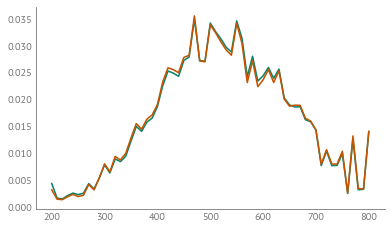

In [45]:
pmf = Pmf(counts_draw, thetas)
pmf.normalize()
pmf.plot(label='draw')

pmf = Pmf(counts_obs, thetas)
pmf.normalize()
pmf.plot(label='observed')

pmf.normalize()
print(pmf.mean())

In [46]:
model = make_model(N_test, counts_draw)

with model:
    idata = pm.sample(target_accept=0.95)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, beta, log_noise_raw]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 82 seconds.


In [47]:
pm.summary(idata, var_names=['mu', 'sigma', 'beta'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,523.944,1.361,521.407,526.277,0.023,0.024,3831.0,2695.0,1.0
sigma,124.533,0.102,124.355,124.734,0.002,0.001,2796.0,2968.0,1.0
beta,0.041,0.018,0.011,0.075,0.000,0.000,3778.0,2714.0,1.0


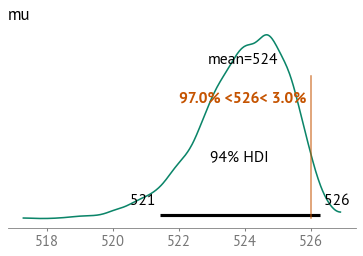

In [48]:
az.plot_posterior(idata, var_names=['mu'], ref_val=true_mu);

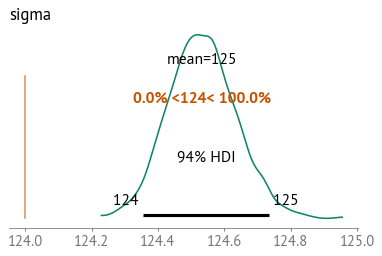

In [49]:
az.plot_posterior(idata, var_names=['sigma'], ref_val=true_sigma);

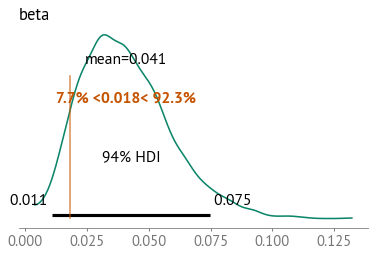

In [50]:
az.plot_posterior(idata, var_names=['beta'], ref_val=true_beta);

## Hierarchical

In [51]:
def get_counts_obs(year, sex):
    return df_map[year].loc[thetas, sex]

In [52]:
years = [2011, 2012, 2013, 2014, 2015]
sexes = ['Male', 'Female']

data = np.array([
    [get_counts_obs(year, sex=sex) for sex in sexes]
    for year in years
])

data.shape  # (n_years, n_sexes, n_scores)

(5, 2, 61)

In [53]:
N_test_obs = data.sum(axis=2)
N_test_obs

array([[770605, 876518],
       [778142, 886337],
       [776092, 883955],
       [783570, 888825],
       [794802, 903719]])

In [54]:
coords = {
    'year': years,
    'sex': sexes,
    'full_score': full_thetas,  # 81
    'score': thetas_centered,     # 61
}

In [55]:
with pm.Model(coords=coords) as model:
    # Data
    data_pt = pm.Data("data", data, dims=("year", "sex", "score"))
    N_test_obs_pt = pm.Data("N_test_obs", N_test_obs, dims=("year", "sex"))

    # Population distribution parameters per sex
    mu = pm.Normal("mu", mu=500, sigma=30, dims="sex")
    sigma = pm.Gamma("sigma", **sigma_params, dims="sex")

    # Base log-probability from the Normal distribution
    logp_vals = pm.logp(pm.Normal.dist(mu=mu[:, None], sigma=sigma[:, None]), 
                        full_thetas[None, :])  # (sex, full_score)

    # Add year-level perturbation (zero-mean across full scores)
    log_noise = pm.ZeroSumNormal("log_noise", sigma=0.05, 
                                 dims=["year", "full_score"])  # (year, full_score)

    # Combine: logp_vals is (sex, full_score), broadcast to (year, sex, full_score)
    perturbed_logp = logp_vals[None, :, :] + log_noise[:, None, :]
    perturbed_logp -= perturbed_logp.mean(axis=-1, keepdims=True)

    # Convert to probabilities
    logp_normalizer = pm.math.logsumexp(perturbed_logp, axis=-1, keepdims=True)
    pop_pdf = pm.Deterministic("pop_pdf", pm.math.exp(perturbed_logp - logp_normalizer))  # (year, sex, full_score)

    # Compute center_pdf and add tail masses
    left_mass = pop_pdf[:, :, left_mask].sum(axis=-1)    # (year, sex)
    right_mass = pop_pdf[:, :, right_mask].sum(axis=-1)  # (year, sex)
    center_pdf = pop_pdf[:, :, center_mask]              # (year, sex, score)

    center_pdf = pt.set_subtensor(center_pdf[:, :, 0],  center_pdf[:, :, 0] + left_mass)
    center_pdf = pt.set_subtensor(center_pdf[:, :, -1], center_pdf[:, :, -1] + right_mass)

    # Selection model
    beta = pm.Gamma("beta", **beta_params, dims=["year", "sex"])
    logits = beta[:, :, None] * thetas_scaled[None, None, :]  # (year, sex, score)
    p_take = pm.Deterministic("p_take", pm.math.sigmoid(logits))

    # Test-taker distribution
    test_unnorm = center_pdf * p_take
    prob_test = test_unnorm.sum(axis=-1)
    test_pdf = test_unnorm / test_unnorm.sum(axis=-1, keepdims=True)

    # Multinomial likelihood for score bins
    pm.Multinomial("obs_bins", n=N_test_obs_pt, p=test_pdf, observed=data_pt, dims=["year", "sex", "score"])

In [56]:
with model:
    idata = pm.sample(target_accept=0.95)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, log_noise, beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 138 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [57]:
pm.summary(idata, var_names=['mu', 'sigma', 'beta'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[Male],509.487,1.328,506.970,511.995,0.068,0.034,376.0,976.0,1.02
mu[Female],502.374,0.291,501.837,502.927,0.012,0.006,547.0,1149.0,1.01
sigma[Male],121.309,0.287,120.772,121.846,0.014,0.007,409.0,887.0,1.01
sigma[Female],112.442,0.115,112.228,112.659,0.010,0.004,143.0,335.0,1.03
"beta[2011, Male]",0.386,0.020,0.346,0.420,0.001,0.000,381.0,956.0,1.02
"beta[2011, Female]",0.039,0.007,0.027,0.052,0.000,0.000,553.0,1033.0,1.00
"beta[2012, Male]",0.397,0.019,0.361,0.433,0.001,0.000,455.0,983.0,1.02
"beta[2012, Female]",0.021,0.006,0.010,0.032,0.000,0.000,679.0,1328.0,1.00
"beta[2013, Male]",0.366,0.019,0.330,0.403,0.001,0.000,371.0,1032.0,1.02
"beta[2013, Female]",0.034,0.007,0.021,0.045,0.000,0.000,605.0,949.0,1.01


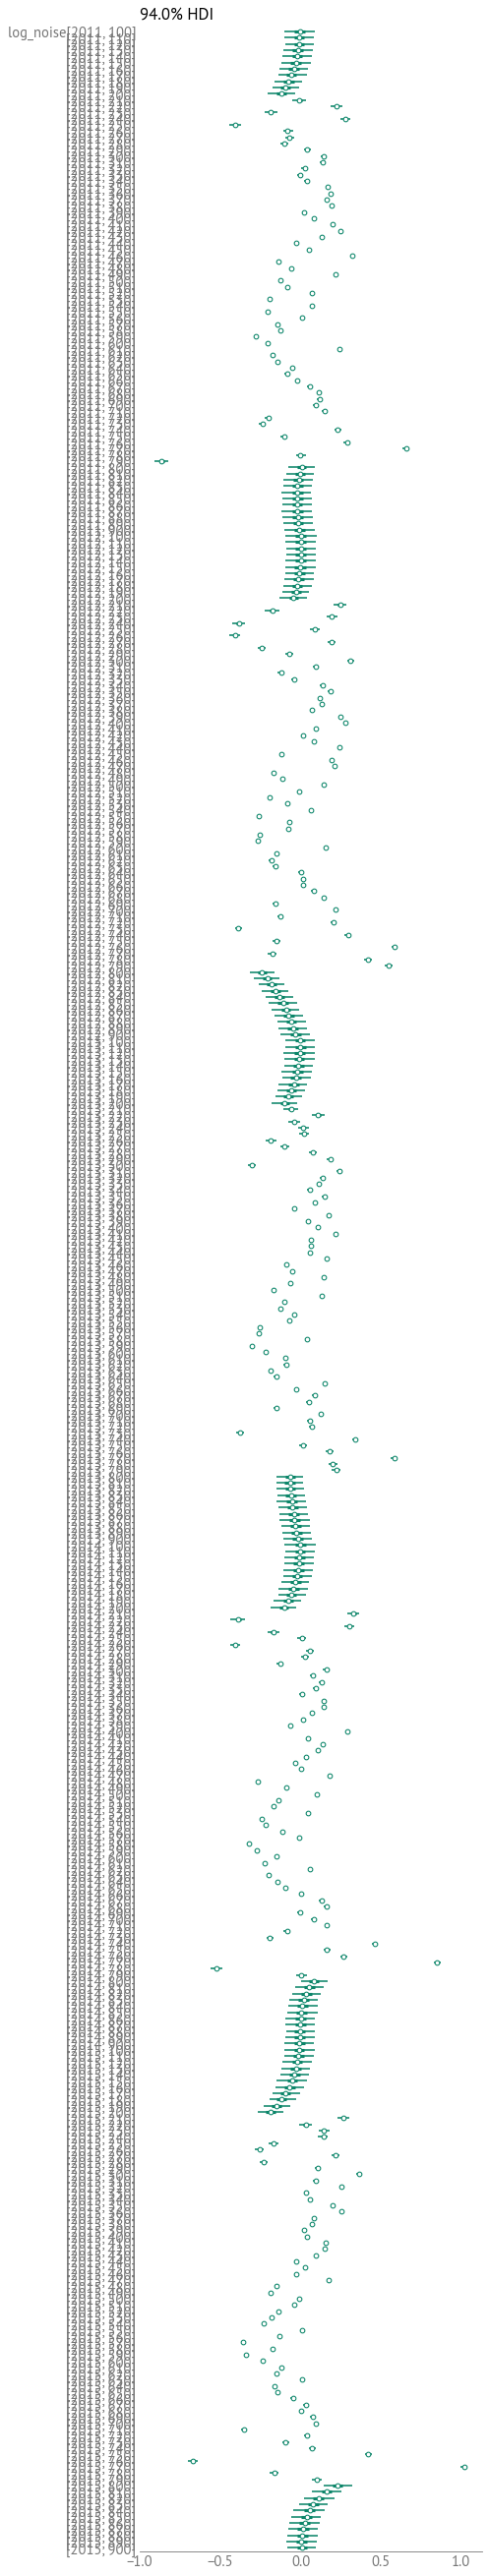

In [58]:
az.plot_forest(idata, var_names='log_noise', combined=True);

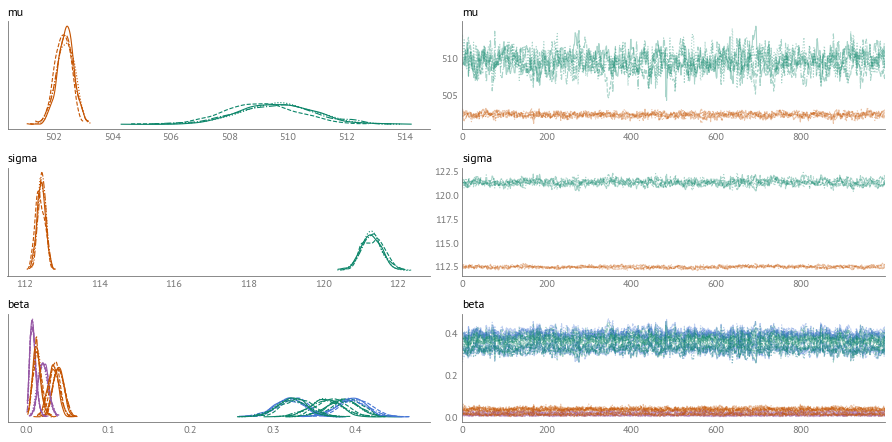

In [59]:
pm.plot_trace(idata, var_names=['mu', 'sigma', 'beta'])
decorate()

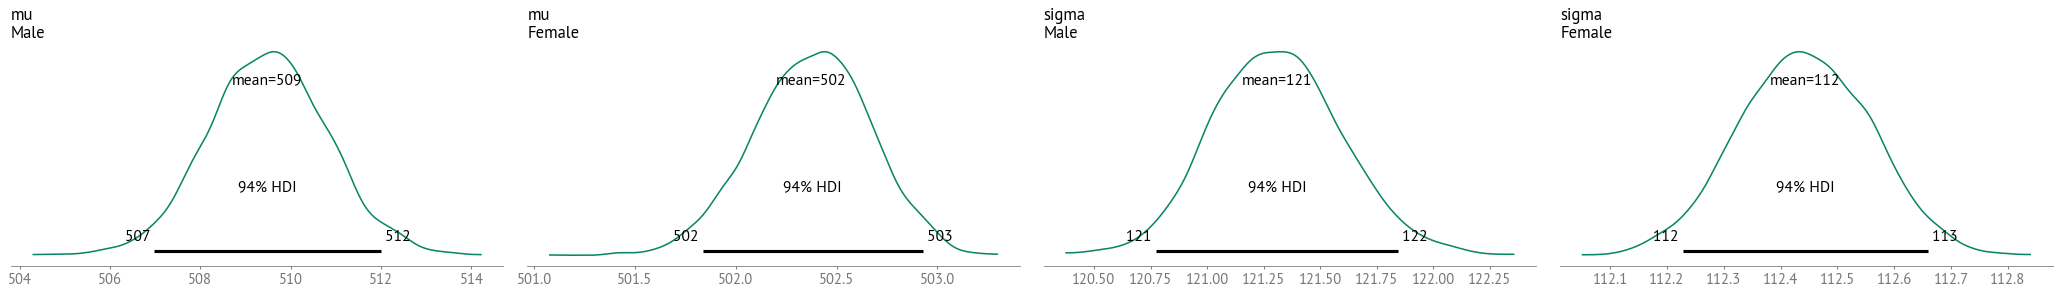

In [60]:
pm.plot_posterior(idata, var_names=['mu', 'sigma'])
decorate()

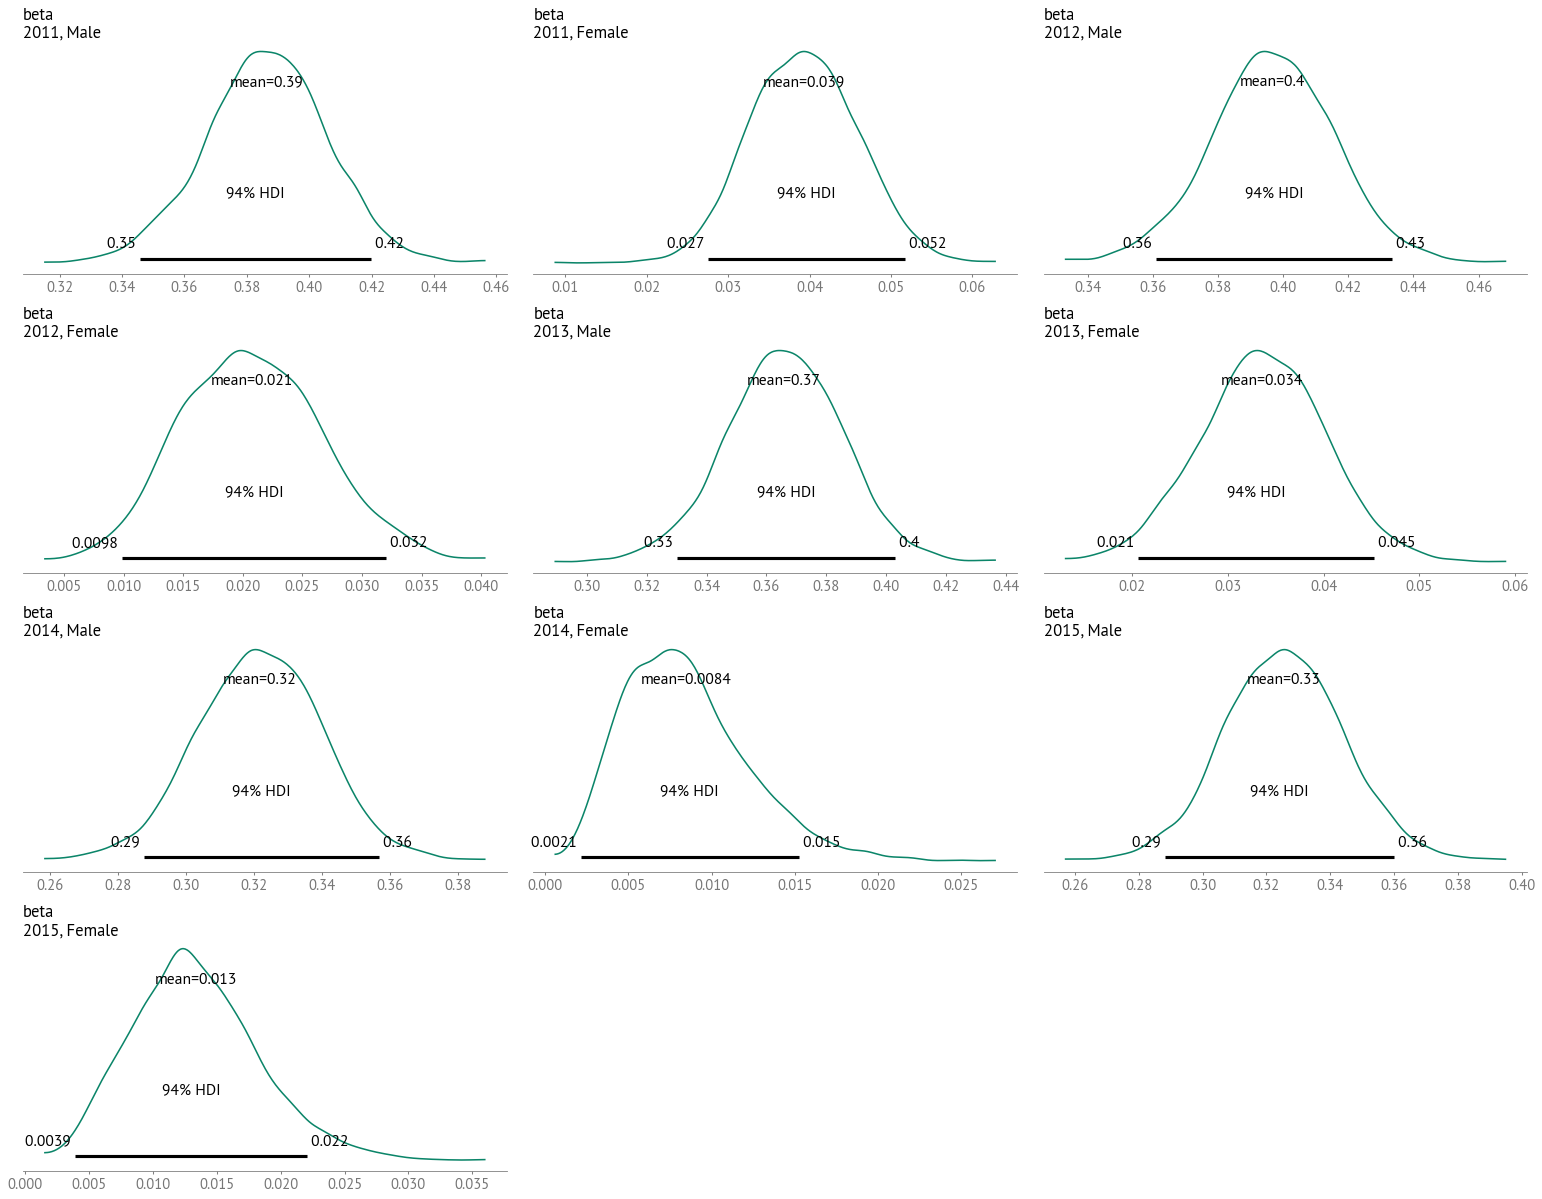

In [61]:
pm.plot_posterior(idata, var_names=['beta'])
decorate()

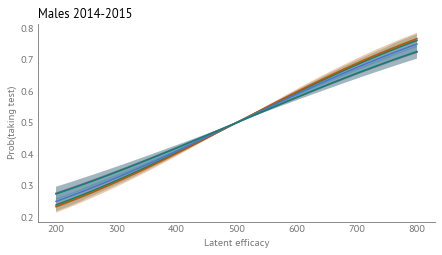

In [62]:
for year in years:
    idata_one = idata.sel(year=year, sex="Male")
    plot_selection_function(idata_one, None, thetas_scaled)
    
decorate(xlabel='Latent efficacy', ylabel='Prob(taking test)', title='Males 2014-2015')

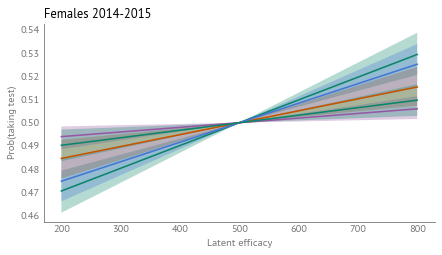

In [63]:
for year in years:
    idata_one = idata.sel(year=year, sex="Female")
    plot_selection_function(idata_one, None, thetas_scaled)
    
decorate(xlabel='Latent efficacy', ylabel='Prob(taking test)', title='Females 2014-2015')

In [64]:
with model:
    post_pred = pm.sample_posterior_predictive(idata)

Sampling: [obs_bins]


Output()

In [65]:
post_pred

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

In [66]:
obs_bins_post_pred = az.extract(post_pred, group='posterior_predictive')['obs_bins']
obs_bins_post_pred

<xarray.DataArray 'obs_bins' (year: 5, sex: 2, score: 61, sample: 4000)> Size: 20MB
array([[[[ 1888,  1949,  1837, ...,  1910,  1912,  2024],
         [  561,   554,   580, ...,   544,   589,   580],
         [  884,   919,   955, ...,   941,   910,   931],
         ...,
         [ 2951,  2922,  2974, ...,  3106,  2962,  3208],
         [ 1054,  1057,  1075, ...,  1085,  1062,  1025],
         [ 9773,  9965,  9937, ...,  9670,  9748,  9891]],

        [[ 3049,  2987,  2932, ...,  2957,  2901,  3017],
         [  980,  1006,   967, ...,   979,   941,   961],
         [ 1529,  1503,  1515, ...,  1567,  1539,  1584],
         ...,
         [ 1561,  1478,  1502, ...,  1474,  1467,  1548],
         [  538,   491,   509, ...,   493,   468,   495],
         [ 4058,  3969,  3882, ...,  3967,  3901,  4058]]],


       [[[ 2049,  2001,  2018, ...,  2052,  1933,  1986],
         [  710,   726,   742, ...,   761,   707,   731],
         [  609,   644,   585, ...,   616,   551,   609],
...
         [ 1264,  1239,  1294, ...,  1208,  1193,  1270],
         [ 4243,  4558,  4022, ...,  4332,  4102,  4216]]],


       [[[ 2375,  2222,  2309, ...,  2324,  2258,  2303],
         [  912,   948,   898, ...,   912,   911,   904],
         [  906,   866,   921, ...,   920,   896,   925],
         ...,
         [ 2719,  2654,  2792, ...,  2761,  2635,  2664],
         [ 2905,  3112,  2944, ...,  2929,  3007,  2799],
         [11518, 11725, 11397, ..., 11548, 11663, 11406]],

        [[ 3278,  3234,  3234, ...,  3280,  3234,  3144],
         [ 1487,  1379,  1388, ...,  1457,  1439,  1449],
         [ 1511,  1380,  1394, ...,  1463,  1382,  1496],
         ...,
         [ 1317,  1438,  1416, ...,  1332,  1394,  1386],
         [ 1358,  1444,  1459, ...,  1382,  1513,  1491],
         [ 4773,  4941,  4793, ...,  4821,  4766,  4734]]]],
      shape=(5, 2, 61, 4000))
Coordinates:
  * year     (year) int64 40B 2011 2012 2013 2014 2015
  * sex      (sex) <U6 48B 'Male' 'Female'
  * score    (score) int64 488B -300 -290 -280 -270 -260 ... 260 270 280 290 300
  * sample   (sample) object 32kB MultiIndex
  * chain    (sample) int64 32kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 32kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999

In [67]:
obs_bins_post_pred.shape

(5, 2, 61, 4000)

In [68]:
medians = np.median(obs_bins_post_pred, axis=-1)
medians.shape

(5, 2, 61)

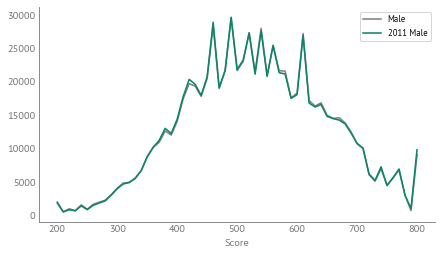

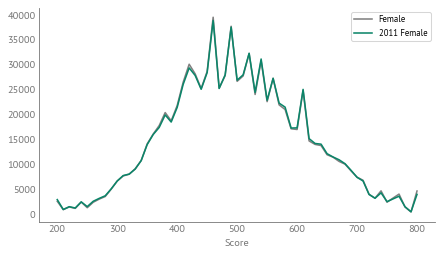

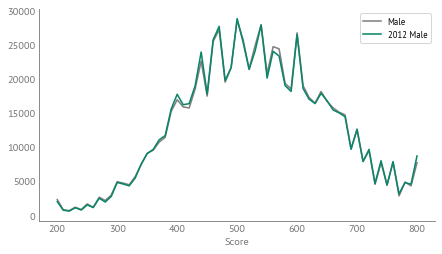

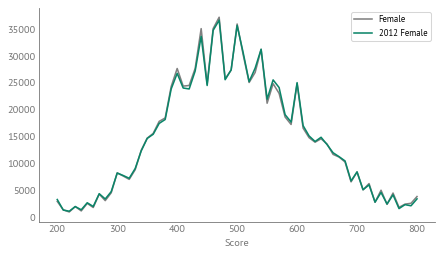

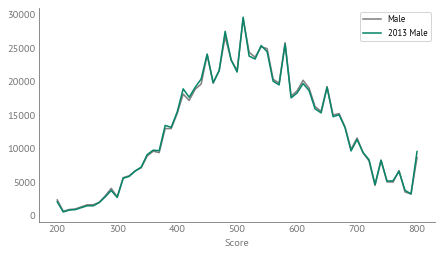

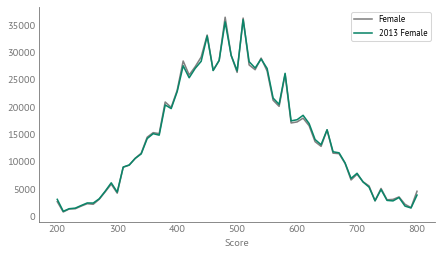

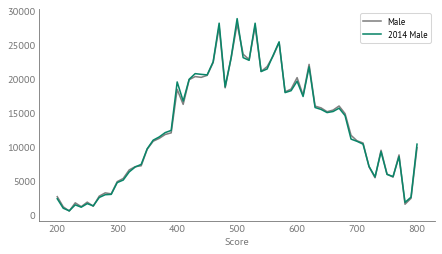

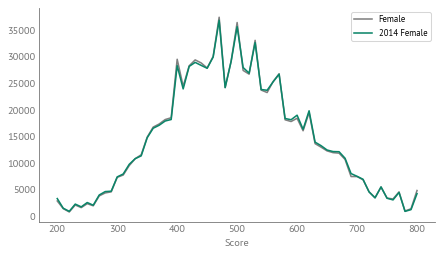

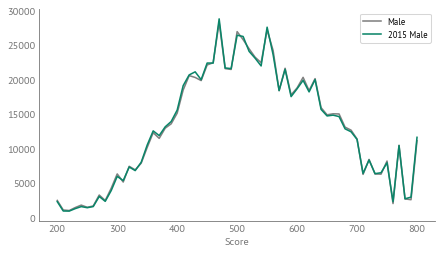

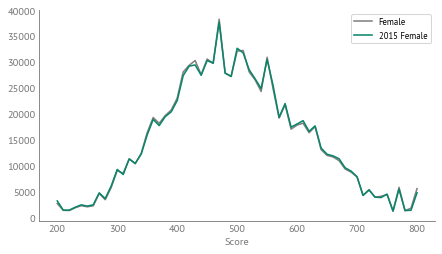

In [69]:
for i, year in enumerate(years):
    for j, sex in enumerate(sexes):
        plt.figure()
        df_map[year][sex].plot(color='gray')
        plt.plot(thetas, medians[i, j], label=f'{year} {sex}')
        decorate()